### ToDo
- split into train/validation/test according to paper
- calculate fingerprints & despriptors
- calculate quantiles
- concatenate 
- normalize between 0 and 1

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
#np.set_printoptions(threshold=np.inf)

from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import Descriptors, rdFingerprintGenerator

from sklearn.preprocessing import StandardScaler
from statsmodels.distributions.empirical_distribution import ECDF

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
# ToxCast
# 8.6k mols, 618 tasks, 1'547'010 (29%) non-nan measurements

toxcast = pd.read_csv("datasets/toxcast_data.csv")

print('Shape: ', toxcast.shape)

vals = toxcast.values.flatten()
print('# meas.: ', len([v for v in vals if str(v) != 'nan']))

toxcast.head()

Shape:  (8615, 618)
# meas.:  1547010


,smiles,ACEA_T47D_80hr_Negative,ACEA_T47D_80hr_Positive,APR_HepG2_CellCycleArrest_24h_dn,APR_HepG2_CellCycleArrest_24h_up,APR_HepG2_CellCycleArrest_72h_dn,APR_HepG2_CellLoss_24h_dn,APR_HepG2_CellLoss_72h_dn,APR_HepG2_MicrotubuleCSK_24h_dn,APR_HepG2_MicrotubuleCSK_24h_up,...,Tanguay_ZF_120hpf_OTIC_up,Tanguay_ZF_120hpf_PE_up,Tanguay_ZF_120hpf_PFIN_up,Tanguay_ZF_120hpf_PIG_up,Tanguay_ZF_120hpf_SNOU_up,Tanguay_ZF_120hpf_SOMI_up,Tanguay_ZF_120hpf_SWIM_up,Tanguay_ZF_120hpf_TRUN_up,Tanguay_ZF_120hpf_TR_up,Tanguay_ZF_120hpf_YSE_up
0,[O-][N+](=O)C1=CC=C(Cl)C=C1,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,C[SiH](C)O[Si](C)(C)O[Si](C)(C)O[SiH](C)C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CN1CCN(CC1)C(=O)C1CCCCC1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NC1=CC=C(C=C1)[N+]([O-])=O,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,OC1=CC=C(C=C1)[N+]([O-])=O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Feature computation

In [3]:
def smile_to_mol(toxcast_data):
    smiles_column = list(toxcast_data['smiles'])
    molecules = []
    valid_rows = []

    # Iterate through each SMILES string
    for index, smiles in enumerate(smiles_column):
        molecule = Chem.MolFromSmiles(smiles)
        
        if molecule is None:
            continue  # Skip invalid SMILES (removing the row)
        else:
            molecules.append(molecule)
            valid_rows.append(index)  # Track valid row indices

    # Filter the DataFrame to only keep rows with valid molecules
    toxcast_data = toxcast_data.iloc[valid_rows].copy()
    
    # Replace the SMILES column with the list of valid RDKit Molecule objects
    toxcast_data['smiles'] = molecules
    toxcast_data.rename(columns={'smiles': 'molecule'}, inplace=True)
    toxcast_data = toxcast_data.reset_index(drop=True)

    return toxcast_data

In [4]:
toxcast_converted_to_molecule = smile_to_mol(toxcast)

In [5]:
def split_dataset(toxcast_data):
    # Separate SMILES column and assay columns
    smiles_column = toxcast_data['molecule']
    assay_columns = toxcast_data.columns[1:]
    

    # Randomly shuffle the assay columns and split into train (60%), validation (20%), and test (20%)
    np.random.seed(42)  # For reproducibility
    shuffled_assays = np.random.permutation(assay_columns)
    
    # Define split ratios
    train_ratio = 0.6
    validation_ratio = 0.2

    # Calculate the number of columns for each set
    train_size = int(len(shuffled_assays) * train_ratio)
    validation_size = int(len(shuffled_assays) * validation_ratio)

    # Split assays
    train_assays = shuffled_assays[:train_size]
    validation_assays = shuffled_assays[train_size:train_size + validation_size]
    test_assays = shuffled_assays[train_size + validation_size:]

    # Create the train, validation, and test sets
    train_set = toxcast_data[['molecule'] + list(train_assays)]
    validation_set = toxcast_data[['molecule'] + list(validation_assays)]
    test_set = toxcast_data[['molecule'] + list(test_assays)]

    return train_set, validation_set, test_set

In [6]:
train_set_raw, validation_set_raw, test_set_raw = split_dataset(toxcast_converted_to_molecule)

In [7]:
def generate_ecfps(df):
    ecfps = list()

    # Extract the 'molecule' column from the DataFrame
    molecules = df['molecule']

    # Generate ECFPs for each molecule in the 'molecule' column
    for molecule in molecules:
        if molecule is None:
            ecfps.append(np.nan)  # Append NaN for None molecules
            continue
        
        fp_sparseVec = rdFingerprintGenerator.GetCountFPs(
                        [molecule], fpType=rdFingerprintGenerator.MorganFP
                       )[0]
        fp = np.zeros((0,), np.int8)  # Generate target pointer to fill
        DataStructs.ConvertToNumpyArray(fp_sparseVec, fp)

        ecfps.append(fp)

    # Convert ECFPs to a list of arrays (or a column that can be appended)
    ecfps = pd.Series(ecfps)

    # Insert the ECFPs column right after the 'molecule' column
    df.insert(loc=df.columns.get_loc('molecule') + 1, column='ecfps', value=ecfps)

    return df

In [8]:
def calc_descriptors(df, descriptor_ids=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,
                  51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,
                  91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,
                  124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,
                  155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,
                  186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207]):
    
    # List to store descriptors for each molecule
    rdkit_descriptors = []
    
    # Extract molecules from the 'molecule' column
    molecules = df['molecule']
    
    # Iterate over molecules and compute descriptors
    for molecule in molecules:
        descrs = list()
        for descr in Descriptors._descList:
            _, descr_calc_fn = descr
            try:
                descrs.append(descr_calc_fn(molecule))
            except:
                pass
        
        # Convert to numpy array and filter by descriptor IDs
        descrs = np.array(descrs)
        descrs = descrs[descriptor_ids]
        rdkit_descriptors.append(descrs)  # Store descriptors for each molecule

    # Add the descriptors list as a new column to the DataFrame
    df.insert(loc=df.columns.get_loc('molecule') + 1, column='descriptors', value=rdkit_descriptors)

    return df

In [9]:
train_set_ecfps_descriptors = calc_descriptors(generate_ecfps(train_set_raw))
validation_set_ecfps_descriptors = calc_descriptors(generate_ecfps(validation_set_raw))
test_set_ecfps_descriptors = calc_descriptors(generate_ecfps(test_set_raw))

In [10]:
def calc_quantiles(train_set, validation_set, test_set):
    # Make sure to work with copies of the sets
    train_set = train_set.copy()
    validation_set = validation_set.copy()
    test_set = test_set.copy()
    
    # List to store quantiles for each set
    train_quantiles = []
    validation_quantiles = []
    test_quantiles = []
    
    # Step 1: Compute ECDF on train set descriptors
    ecdf_values = ECDF(train_set['descriptors'].explode())  # Explode if 'descriptors' are lists in each row
    
    # Step 2: Calculate quantiles for train set
    for index, row in train_set.iterrows():
        quantiles = np.array(ecdf_values(row['descriptors']))  # Convert to numpy array
        train_quantiles.append(quantiles)
    
    # Step 3: Calculate quantiles for validation set
    for index, row in validation_set.iterrows():
        quantiles = np.array(ecdf_values(row['descriptors']))  # Convert to numpy array
        validation_quantiles.append(quantiles)
        
    # Step 4: Calculate quantiles for test set
    for index, row in test_set.iterrows():
        quantiles = np.array(ecdf_values(row['descriptors']))  # Convert to numpy array
        test_quantiles.append(quantiles)
    
    # Step 5: Insert quantiles as a new column after 'molecule'
    train_set.insert(train_set.columns.get_loc('molecule') + 1, 'quantiles', train_quantiles)
    validation_set.insert(validation_set.columns.get_loc('molecule') + 1, 'quantiles', validation_quantiles)
    test_set.insert(test_set.columns.get_loc('molecule') + 1, 'quantiles', test_quantiles)
    
    # Step 6: Drop the 'descriptors' column
    train_set = train_set.drop(columns=['descriptors'])
    validation_set = validation_set.drop(columns=['descriptors'])
    test_set = test_set.drop(columns=['descriptors'])
    
    return train_set, validation_set, test_set

In [11]:
train_set_ecdf, validation_set_ecdf, test_set_ecdf = calc_quantiles(train_set_ecfps_descriptors, validation_set_ecfps_descriptors, test_set_ecfps_descriptors)

In [12]:
def normalize_quantiles(df):
    # Initialize the scaler
    scaler = StandardScaler()

    # Define function to scale each descriptor set
    def normalize_descriptor_set(descriptor_set):
        if len(descriptor_set) == 0:  # Handle empty sets
            return np.array([])  # Return an empty array if the set is empty
        # Reshape to fit StandardScaler (expects 2D input)
        descriptor_set = np.array(descriptor_set).reshape(-1, 1)
        scaled_set = scaler.fit_transform(descriptor_set).flatten()  # Scale and flatten back to 1D
        return scaled_set  # Return as a NumPy array

    # Apply normalization to each entry in 'quantiles' without converting back to list
    df['quantiles'] = df['quantiles'].apply(normalize_descriptor_set)

    return df

In [13]:
train_set_norm = normalize_quantiles(train_set_ecdf)
validation_set_norm = normalize_quantiles(validation_set_ecdf)
test_set_norm = normalize_quantiles(test_set_ecdf)

In [14]:
def merge_quantiles_ecfps(df):
     # Concatenate 'quantiles' and 'ecfps' into a new column 'quantilesXecfps'
    df['quantilesXecfps'] = df.apply(lambda row: np.concatenate((row['quantiles'], row['ecfps'])), axis=1)
    
    # Find the index of the 'molecule' column
    molecule_index = df.columns.get_loc('molecule')
    
    # Insert the new column after 'molecule'
    df.insert(molecule_index + 1, 'quantilesXecfps', df.pop('quantilesXecfps'))
    
    # Drop the original 'quantiles' and 'ecfps' columns
    df = df.drop(columns=['quantiles', 'ecfps'])
    
    return df

In [15]:
train_set = merge_quantiles_ecfps(train_set_norm)
validation_set = merge_quantiles_ecfps(validation_set_norm)
test_set = merge_quantiles_ecfps(test_set_norm)

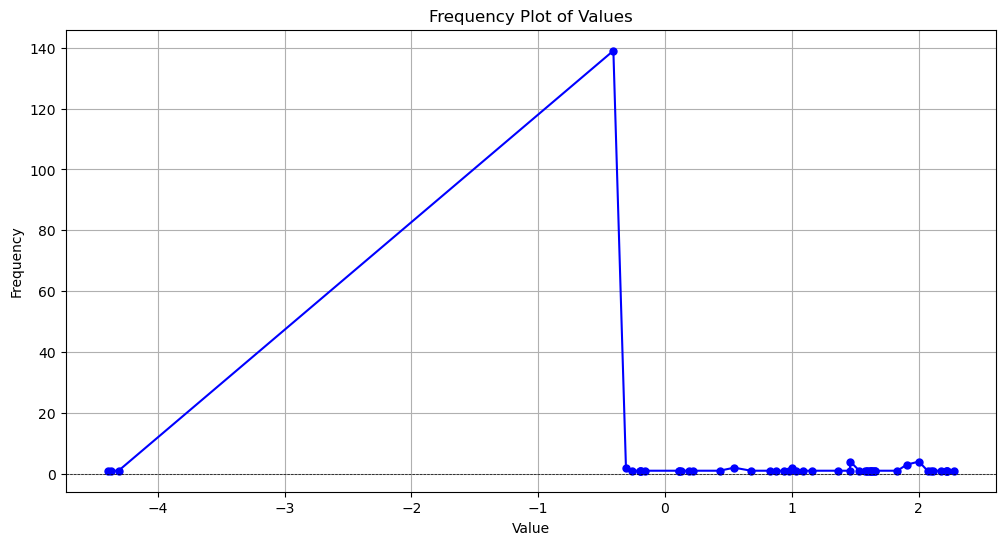

In [16]:
data = train_set_norm["quantiles"][1]

# Count the frequency of each unique value
values, frequencies = np.unique(data, return_counts=True)

# Create a line plot
plt.figure(figsize=(12, 6))  # Set the figure size
plt.plot(values, frequencies, marker='o', linestyle='-', color='b', markersize=5)  # Plot the data
plt.title('Frequency Plot of Values')  # Title of the plot
plt.xlabel('Value')  # Label for the x-axis
plt.ylabel('Frequency')  # Label for the y-axis
plt.grid(True)  # Show grid
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')  # Add a horizontal line at y=0
plt.show()  # Display the plot

In [17]:
def preprocess_for_pickle(df):
    df_copy = df.copy()
    # Convert RDKit molecule objects to SMILES strings
    df_copy['molecule'] = df_copy['molecule'].apply(lambda mol: Chem.MolToSmiles(mol) if mol else None)
    return df_copy

In [18]:
train_set_export = preprocess_for_pickle(train_set)
validation_set_export = preprocess_for_pickle(validation_set)
test_set_export = preprocess_for_pickle(test_set)

# Save all three DataFrames to a single pickle file
with open("datasets/datasets.pkl", "wb") as f:
    pickle.dump({"train": train_set_export, "validation": validation_set_export, "test": test_set_export}, f)